In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf


from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from skimage.feature import hog
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import time
from IPython.display import Image

!pip install facenet-pytorch

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red"> r0965824, r0980444, r0974272, r0974660, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

### 0.1.1 Extra data step
Every ML Model requires a lot of data to run. In case we want to add extra data we can do it with two different ways. For example we can:
- Scrap data from the internet
- Create augmentation of the data by creating diverse images from the original ones

In [ ]:
# We add new images from the pinterest 
!pip install pinscrape
DIR_A = "mila_extra_images_A"
DIR_B = "jesse_extra_images_B"
# from pinscrape import pinscrape
# _ = pinscrape.scraper.scrape("mila kunis face", DIR_A, {}, 20, 30)
# _ = pinscrape.scraper.scrape("jesse eisenberg face", DIR_B, {}, 20, 30)

def easy_load(dir, name):
    """
    This method loads the directories of the images from the respective directory
    and load the images in one dataframe with the format of the test dataset

    :param dir: directory path
    :param name: the name of the Actor can be Mila_Kunis or Jesse_Eisenberg
    :return: describe what it returns
    """
    data = []
    for filename in os.listdir(dir):
            img_path = os.path.join(dir, filename)
            print(img_path)
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image loaded successfully
                if name == "Mila_Kunis":
                    data.append([name, 2, img])
                else:
                    data.append([name, 1, img])
                    
    return pd.DataFrame(data, columns=["name", "class", "img"])
        
# df_mila = easy_load(DIR_A, "Mila_Kunis")
# df_jesse = easy_load(DIR_B, "Jesse_Eisenberg")

In [ ]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/train_set.csv', index_col=0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/test_set.csv', index_col=0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB)
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB)
               for index, row in test.iterrows()]


train_size, test_size = len(train), len(test)

"The training set contains {} examples, the test set contains {} examples.".format(
    train_size, test_size)

In [ ]:
train.head(10)

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [ ]:
# The training set contains an identifier, name, image information and class label
train.head(5)
plt.imshow(train.loc[1, 'img'])

### 0.2.1 Remove bad quality data
After examing carefully the data we observed that some data was problematic. For the first approach we decided to follow the simplest solution and remove them by hand. The size was reduced to 70 images in total.

In [ ]:
# The class distribution in the training set:
train.groupby('name').agg({'img': 'count', 'class': 'max'})
index = [14, 23, 24, 28, 35, 40, 49, 57, 64, 65]
# some images are corrupted that'y why I remove them manually
train.drop(train.index[index], inplace=True)
train.groupby('name').agg({'img': 'count', 'class': 'max'})

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [ ]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """

    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path):
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)

        self.classifier = cv2.CascadeClassifier(file_path)

    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"

        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())

    def detect_faces(self, img):
        """Detect all faces in an image."""

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""

        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]

    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])

        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img

        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation=cv2.INTER_AREA)

    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [ ]:
# parameter to play with
FACE_SIZE = (100, 100)


def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f, ax = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row), int(i % imgs_per_row)].imshow(data[i])
        else:
            ax[int(i % n)].imshow(data[i])
    plt.show()


# preprocessed data
preprocessor = HAARPreprocessor(path='../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)

In [ ]:
print(len(train_X))

### Here comes the plot with the 70 faces!!!

In [ ]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X, n=70, imgs_per_row=10)

In [ ]:
# Define threshold for edge coverage
edge_coverage_threshold = 0.03  # Adjust as needed

# Empty lists to store filtered images and labels
filtered_images = []  # Renamed from train_x_filtered
filtered_labels = []  # Renamed from labels_filtered
filtered_out = []     # Renamed from filtered

# Loop through each image
for i in range(train_X.shape[0]):
    image = train_X[i]

    # Convert to grayscale
    gray = cv2.cvtColor(np.uint8(image), cv2.COLOR_RGB2GRAY)

    # Perform Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Calculate the proportion of edge pixels compared to total pixels
    edge_pixel_count = np.sum(edges > 0)
    total_pixels = edges.shape[0] * edges.shape[1]
    edge_proportion = edge_pixel_count / total_pixels

    # Display the original image and the edges
    if i == 1:
        plt.imshow(image)
        plt.show()
        plt.imshow(edges, cmap='gray')
        plt.show()

    # Check if the proportion of edge pixels is greater than the threshold
    if edge_proportion > edge_coverage_threshold:
        filtered_images.append(image)
        filtered_labels.append(train_y[i])
    else:
        print("Filtered image")
        filtered_out.append(image)

# Convert lists to numpy arrays
filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)
filtered_out = np.array(filtered_out)

# Store Data

In [ ]:
# Save preprocessed data to Kaggle temporary directory
prep_path = '/kaggle/working/'
if not os.path.exists(prep_path):
    os.makedirs(prep_path)

np.save(os.path.join(prep_path, 'filtered_images.npy'), filtered_images)
np.save(os.path.join(prep_path, 'filtered_labels.npy'), filtered_labels)
np.save(os.path.join(prep_path, 'filtered_out.npy'), filtered_out)

# Save preprocessed test data
np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)

# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

### Data Augmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, transform
from skimage.util import random_noise
from skimage.transform import rotate
import os

output_folder = '/kaggle/working/'
# Step 2: Specify the path where the data is stored
data_path = '/kaggle/working/'
# Step 3: Load the data into NumPy arrays
filtered_images = np.load(os.path.join(data_path, 'filtered_images.npy'))
filtered_labels = np.load(os.path.join(data_path, 'filtered_labels.npy'))
filtered_out = np.load(os.path.join(data_path, 'filtered_out.npy'))
test_X = np.load(os.path.join(data_path, 'test_X.npy'))


def save_images(images, output_folder, transformation):

    for j, augmented_data in enumerate(images):
        output_file_path = os.path.join(
            output_folder, f'{transformation}_image_{j}.npy')
        np.save(output_file_path, augmented_data)

In [ ]:
from skimage.transform import warp, AffineTransform


def apply_horizontal_flip(images):
    augmented_data_list = []
    for image in images:
        augmented_data = np.fliplr(image)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


horizontal_flip_images = apply_horizontal_flip(filtered_images)
save_images(horizontal_flip_images, output_folder, "horizontal_flip")

# Vertical Flip


def apply_vertical_flip(images):
    augmented_data_list = []
    for image in images:
        augmented_data = np.flipud(image)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


vertical_flip_images = apply_vertical_flip(filtered_images)
save_images(vertical_flip_images, output_folder, "vertical_flip")


def apply_gamma_correction(images, gamma_value=0.3):
    augmented_data_list = []

    for image in images:
        image = image.astype(np.uint8)
        augmented_data = exposure.adjust_gamma(
            image, gamma=gamma_value, gain=0.9)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


gamma_corrected_images = apply_gamma_correction(filtered_images)
save_images(gamma_corrected_images, output_folder, "gamma_corrected")


def apply_logarithmic_correction(images):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        image = image.astype(np.uint8)
        augmented_data = exposure.adjust_log(image)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


log_corrected_images = apply_logarithmic_correction(filtered_images)
save_images(log_corrected_images, output_folder, "log_corrected")


def apply_sigmoid_correction(images):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        augmented_data = exposure.adjust_sigmoid(image)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


sigmoid_corrected_images = apply_sigmoid_correction(filtered_images)
save_images(sigmoid_corrected_images, output_folder, "sigmoid_corrected")


def apply_lighter_image(images):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        augmented_data = exposure.adjust_gamma(image, gamma=0.5, gain=1)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


lighter_images = apply_lighter_image(filtered_images)
save_images(lighter_images, output_folder, "lighter")


def apply_darker_image(images):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        augmented_data = exposure.adjust_gamma(image, gamma=2, gain=1)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


darker_images = apply_darker_image(filtered_images)
save_images(darker_images, output_folder, "darker")


def apply_noisy_image(images):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        augmented_data = random_noise(image)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


noisy_images = apply_noisy_image(filtered_images)
save_images(noisy_images, output_folder, "noisy")


def apply_clockwise_rotation(images, angle=45):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        augmented_data = rotate(image, angle=angle)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


clockwise_rotated_images = apply_clockwise_rotation(filtered_images)
save_images(clockwise_rotated_images, output_folder, "clockwise_rotated")


def apply_anticlockwise_rotation(images, angle=45):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        augmented_data = rotate(image, angle=-angle)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


anticlockwise_rotated_images = apply_anticlockwise_rotation(filtered_images)
save_images(anticlockwise_rotated_images,
            output_folder, "anticlockwise_rotated")

clockwise_rotated_images = apply_clockwise_rotation(filtered_images)
save_images(clockwise_rotated_images, output_folder, "clockwise_rotated")


def apply_width_shift(images, shift_range=0.2):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        max_shift = shift_range * image.shape[1]
        shift = np.random.uniform(-max_shift, max_shift)
        transform = AffineTransform(translation=(shift, 0))
        augmented_data = warp(image, transform.inverse)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


# Apply width shift transformation
width_shift_images = apply_width_shift(filtered_images)
# Ask to save all width shift images
save_images(width_shift_images, output_folder, "width_shift")


def apply_height_shift(images, shift_range=0.2):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        max_shift = shift_range * image.shape[0]
        shift = np.random.uniform(-max_shift, max_shift)
        transform = AffineTransform(translation=(0, shift))
        augmented_data = warp(image, transform.inverse)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


# Apply height shift transformation
height_shift_images = apply_height_shift(filtered_images)
# Ask to save all height shift images
save_images(height_shift_images, output_folder, "height_shift")


def apply_shear(images, shear_range=0.2):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        shear_factor = np.random.uniform(-shear_range, shear_range)
        transform = AffineTransform(shear=shear_factor)
        augmented_data = warp(image, transform.inverse)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


# Apply shear transformation
shear_images = apply_shear(filtered_images)
# Ask to save all shear images
save_images(shear_images, output_folder, "shear")


def apply_zoom(images, zoom_range=0.2):
    augmented_data_list = []
    for image in images:
        image = image.astype(np.uint8)
        zoom_factor = 1 + np.random.uniform(-zoom_range, zoom_range)
        transform = AffineTransform(scale=(zoom_factor, zoom_factor))
        augmented_data = warp(image, transform.inverse)
        augmented_data_list.append(augmented_data)
    return augmented_data_list


# Apply zoom transformation
zoom_images = apply_zoom(filtered_images)
# Ask to save all zoom images
save_images(zoom_images, output_folder, "zoom")


def load_augmented_data_with_labels(output_folder, filtered_labels):
    images = []
    labels = []
    output_files = os.listdir(output_folder)
    for filename in output_files:
        if filename.endswith('.npy') and 'X' not in filename:
            parts = filename.split('_')
            if len(parts) >= 3:
                index_str = parts[-1].split('.')[0]
                index = int(index_str)
                label = filtered_labels[index]
                augmented_data = np.load(os.path.join(output_folder, filename))
                images.append(augmented_data)
                labels.append(label)
    assert len(images) == len(
        labels), "Number of images and labels should match"
    return np.array(images), np.array(labels)

For the ML approach we used only the augmentations below

In [ ]:
augmented_train_X = np.concatenate([
    train_X,
    anticlockwise_rotated_images,
    clockwise_rotated_images,
], axis=0)
augmented_y = [item for sublist in np.tile(
    train_y, (3, 1)) for item in sublist]

In [ ]:
print(len(augmented_train_X))
print(len(augmented_y))

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""

    def transform(self, X):
        return X

    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
Histogram of Oriented Gradients (HOG) is a feature descriptor that extracts characteristic objects or shapes from an image. The feature descriptors will be used later in the pipeline as input to a classifier. 
A brief step-by-step overview of how HOG feature descriptors are extracted is as follows:
*     Preprocessing the image (resize, in this case the aspect ratio is set to 1:1) Calculate the gradient of the image. 
* Split the image in cells (e.g. 4x4) and make a histogram of the gradients for each cell by pooling them in bins based on direction and magnitude. 
* Normalize over a block (neighborhood of cells) to create descriptors invariant to lighting variations.


The HOG implementation in OpenCV takes several input arguments including:
 - The cell size (cellSize) typically captures the size of the image features of interest.
 - The block size (blockSize) tackles the problem of variation in illumination.
 - The number of histogram bins (nbins) to capture gradients between 0 and 180 degrees.                                       
 
 
After running several pipeline of the following steps 
Load Data -> Extract Faces -> Extract Features -> Train Model -> Get Results ! 
The best params are the following:
- cell_size = (4,4) With a small cell size we can capture more local information but requires more time to run.
- block_size = (4,4) The block size determines the spatial extent over which the histogram features are normalized.
- nbins = 9 Small number of bins in order to remove the noise

In [ ]:
class HOGFeatureExtractor():

    def __init__(self, cell_size=(4, 4), block_size=(4, 4), nbins=9):
        self.cell_size = cell_size
        self.block_size = block_size
        self.nbins = nbins

    def transform(self, faces: np.ndarray):

        all_features = []
        visual_hog_representations = []
        for face in faces:
            face = np.array(face, dtype='uint8')
            face = cv2.resize(face, (FACE_SIZE))
            fd, hog_image = hog(face, orientations=self.nbins, pixels_per_cell=self.cell_size,
                                cells_per_block=self.block_size, visualize=True, channel_axis=2, transform_sqrt=False)

            all_features.append(fd)
            visual_hog_representations.append(hog_image)
        return all_features, visual_hog_representations

    def __call__(self, X):
        return self.transform(X)


extractor = HOGFeatureExtractor()
other_hog_feature_descriptors, other_hog_representations = extractor(
    train_X[train_y == 0])
jesse_hog_feature_descriptors, jesse_hog_representations = extractor(
    train_X[train_y == 1])
mila_hog_feature_descriptors, mila_hog_representations = extractor(
    train_X[train_y == 2])

hog_feature_descriptors = [*other_hog_feature_descriptors, *
                           jesse_hog_feature_descriptors, *mila_hog_feature_descriptors]

plot_image_sequence(mila_hog_representations,
                    len(mila_hog_representations), 8)

In [ ]:
extractor = HOGFeatureExtractor(cell_size=(8, 8), block_size=(8, 8))
other_hog_feature_descriptors, other_hog_representations = extractor(
    train_X[train_y == 0])
jesse_hog_feature_descriptors, jesse_hog_representations = extractor(
    train_X[train_y == 1])
mila_hog_feature_descriptors, mila_hog_representations = extractor(
    train_X[train_y == 2])

hog_feature_descriptors = [*other_hog_feature_descriptors, *
                           jesse_hog_feature_descriptors, *mila_hog_feature_descriptors]

plot_image_sequence(mila_hog_representations,
                    len(mila_hog_representations), 8)

Disclaimer!! The aim of the above plots is to depict how cell size and block size affects the feature representation of the images. We can see that the smaller cell size and block size performs much better by providing a more fined granularity. 

### 1.1.2. Baseline 1 Alternative: Scale Invariant Feature Transform (SIFT) Feature extractor

As a potential improvement, we also tried extracting feature descriptors using the scale invariant feature transform (SIFT).
SIFT is slightly more complicated in practise than HOG and produces very different feature descriptors. To briefly describe SIFT:
1. Find the difference of gaussian (DOG) in multiple scales (called octaves)
2. Identify local maxima and minima as keypoint locations by comparing each pixel with neighboring pixels in its own scale as well as with pixels in different scales. This way we find the scale that better represents the keypoint.
3. For each potential keypoint, the location, scale, and orientation are refined using Taylor series expansion.
4. Keypoints with low contrast (contrastThreshold variable in the initialization below) are discarded.
5. Edge keypoints are also discarded (edge threshold in the initialization below)
6. Orientation is assigned based on gradient directions.
7. Produce keypoint descriptors by taking a 16x16 window around each keypoint. The window is divided into 16 sub-blocks and an orientation histogram is produced for each. This time we use 8 bins.

In [ ]:
class SIFTFeatureExtractor():

    def __init__(self, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6):
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold
        self.sigma = sigma

    def transform(self, faces: np.ndarray):
        keypoints_per_face = []
        all_features = []
        sift = cv2.SIFT_create(contrastThreshold=self.contrastThreshold,
                               edgeThreshold=self.edgeThreshold, sigma=self.sigma)
        for face in faces:
            face = np.array(face, dtype='uint8')
            face = cv2.resize(face, (FACE_SIZE))
            grayface = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            kp, des = sift.detectAndCompute(grayface, None)
            keypoints_per_face.append(kp)
            all_features.append(des)
        return all_features, keypoints_per_face

    def __call__(self, X):
        return self.transform(X)


sift_extractor = SIFTFeatureExtractor()

Now to visualize some of these descriptors along with their orientation:

In [ ]:
other_sift_feature_descriptors, other_sift_keypoints = sift_extractor(
    train_X[train_y == 0])
jesse_sift_feature_descriptors, jesse_sift_keypoints = sift_extractor(
    train_X[train_y == 1])
mila_sift_feature_descriptors, mila_sift_keypoints = sift_extractor(
    train_X[train_y == 2])

sift_feature_descriptors = [*other_hog_feature_descriptors, *
                            jesse_hog_feature_descriptors, *mila_hog_feature_descriptors]
imgs = []
for i, face in enumerate(train_X[train_y == 2]):
    face = np.array(face, dtype='uint8')
    face = cv2.resize(face, (FACE_SIZE))
    grayface = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    img = cv2.drawKeypoints(
        grayface, mila_sift_keypoints[i], face, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    imgs.append(img)
plot_image_sequence(imgs, len(imgs), 8)

### 1.1.1. t-SNE Plots
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a method for visualizing high-dimensional data in lower-dimensional space. It works by calculating the similarity between data points and mapping it into lower-dimensional space, in this case 2D. The goal is to see some form of pattern which indicates difference between the feature descriptors of Mila, Jesse and everyone else. 

Setting use_SIFT to True will plot t-SNE for the SIFT feature descriptors. By default the plot is about HOG feature descriptors.

In [ ]:
use_SIFT = False
fd = sift_feature_descriptors if use_SIFT else hog_feature_descriptors
other_fd = other_sift_feature_descriptors if use_SIFT else other_hog_feature_descriptors
jesse_fd = jesse_sift_feature_descriptors if use_SIFT else jesse_hog_feature_descriptors
mila_fd = mila_sift_feature_descriptors if use_SIFT else mila_hog_feature_descriptors

tsne = TSNE(n_components=3, perplexity=30)
tnse_result = tsne.fit_transform(
    np.array(fd))
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tnse_result[:, 0]

ty = tnse_result[:, 1]

fig = plt.figure()

ax = fig.add_subplot(111)
# class other
current_tx = tx[:len(other_fd)]
current_ty = ty[:len(other_fd)]
color = np.array((255, 0, 0), dtype=np.float32) / 255
ax.scatter(current_tx, current_ty, color=color, label='other')
# class jesse
current_tx = tx[len(other_fd):len(jesse_fd) + len(other_fd)]
current_ty = ty[len(other_fd):len(jesse_fd) + len(other_fd)]
color = np.array((0, 255, 0), dtype=np.float32) / 255
ax.scatter(current_tx, current_ty, color=color, label='jesse')
# class mila
current_tx = tx[len(jesse_fd) + len(other_fd):]
current_ty = ty[len(jesse_fd) + len(other_fd):]
color = np.array((0, 0, 255), dtype=np.float32) / 255
ax.scatter(current_tx, current_ty, color=color, label='mila')

ax.legend()
plt.show()

### 1.1.2. Discussion
Although the scatter plot will be different each time, two relatively seperate clusters should be visible for the datapoints of Mila and Jesse. The datapoints labeled as "other" are datapoints from Michael and Sarah who look similar to Mila and Jesse and thus partake in both clusterings.

In [ ]:
print(tnse_result[0])

## 1.2. Baseline 2: PCA feature extractor
To extract features by "comparing" our data points and ultimately build a feature vector, we can use Principal Components Analysis (PCA). Principal Component Analysis uses Matrix Decomposition to gain insights about the distribution of data along its orthogonal basis vectors.

Since we work with GrayScale pictures our image data is a square 2D matrix. Since we have n pictures we have a 3D matrix with the dimension n x height x width. To obtain a 2D matrix which is needed for PCA, we need to reshape the image vector by appending the image matrix's column vectors. As a result, we obtain a vector with dimensionality 14400, so that the final matrix is n x 14400.

Mean subtraction is applied to center our intensity data of each image, as Principal Component Analysis requires centered data to work optimally. 

We use Singular Value Decomposition, as we don’t have a symmetric matrix. The number of non-zero singular values typically corresponds to the dimensionality of the selected feature space or the rank of the data matrix. Ideally (in case of non-zero variance) we would have as many non-zero eigenvalues as the minimum between the number of image vectors and the number of dimensions in the image vector. In our case the number of non-zero eigenvalues depends on n_components, that is set to the number of pictures n.  

In [ ]:
class PCAFeatureExtractor(IdentityFeatureExtractor):

    def __init__(self, identity, n_components, FACE_SIZE):
        super().__init__()
        self.n_components = n_components
        self.w = FACE_SIZE[0]
        self.h = FACE_SIZE[1]

    def picturesToGrayScale(self, X):
        grayscale_images = np.empty(
            (X.shape[0], X.shape[1], X.shape[2]), dtype=int)
        for i, img_matrix in enumerate(train_X):
            img_matrix = img_matrix.astype(np.uint8)
            imgFrame = cv2.cvtColor(img_matrix, cv2.COLOR_BGR2GRAY)
            grayscale_images[i] = imgFrame
        return grayscale_images

    def getMean(self, grayX):
        mean_img_frame = np.mean(grayX, axis=0)
        mean_img_frame = mean_img_frame.astype(np.uint8)
        return mean_img_frame

    def getCenteredImage(self, grayX, meanX):
        img_frames_centered = grayX - meanX
        return img_frames_centered

    def getImageMatrix(self, centeredX):
        return (np.reshape(centeredX, (centeredX.shape[0], self.w * self.h)))

    def pCA(self, X2d):
        pca = PCA(n_components=self.n_components)
        pca.fit_transform(X2d)
        return (pca)

    def plotExplainedVariance(self, pca):
        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(1, self.n_components + 1),
                pca.explained_variance_ratio_)
        plt.title("Explained Variance per Eigenface")
        plt.xlabel('Eigenfaces')
        plt.ylabel('Explained Variance')

        plt.show()

    def plotEigenfaces(self, pca):
        fig = plt.figure(figsize=(10, 6))
        fig.subplots_adjust(left=0, right=1, bottom=0,
                            top=1, hspace=0.05, wspace=0.05)
        for i in range(20):
            ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
            ax.imshow(np.reshape(pca.components_[
                      i, :], (self.h, self.w)), cmap=plt.cm.bone, interpolation='nearest')

        plt.show()

    def plotReconstructFace(self, kEigenfaces, pictureIndex, grayX, meanX, X2d, pca):
        # a vector of k coefficients, one for each of the k eigenfaces (for different values of k)
        face_coeffs = np.dot(
            X2d[pictureIndex], pca.components_[:kEigenfaces].T)
        reconstructed_face = np.dot(face_coeffs, pca.components_[
                                    :kEigenfaces]) + meanX.flatten()
        array_2d = np.reshape(reconstructed_face, (self.h, self.w))
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(np.reshape(grayX[pictureIndex], (self.h, self.w)),
                       cmap=plt.cm.bone, interpolation='nearest')
        axes[0].set_title(f'Original (#{pictureIndex})')
        axes[1].imshow(array_2d, cmap=plt.cm.bone, interpolation='nearest')
        axes[1].set_title(f'Reconstruction with {kEigenfaces} Eigenfaces')

        plt.show()

    def plotSequentialReconstructFace(self, pictureIndex, grayX, meanX, X2d, pca):
        reconstructedFaces = []
        counter = 0
        for kEigenfaces in range(1, self.n_components + 1, 5):
            # a vector of k coefficients, one for each of the k eigenfaces (for different values of k)
            face_coeffs = np.dot(
                X2d[pictureIndex], pca.components_[:kEigenfaces].T)
            reconstructed_face = np.dot(face_coeffs, pca.components_[
                                        :kEigenfaces]) + meanX.flatten()
            array_2d = np.reshape(reconstructed_face, (self.h, self.w))
            reconstructedFaces.append(array_2d)
            counter += 1

        fig = plt.figure(figsize=(10, 8))
        fig.suptitle('Sequential Reconstruction of Face', fontsize=16)
        fig.subplots_adjust(left=0, right=1, bottom=0,
                            top=0.9, hspace=0.2, wspace=0.05)

        for i in range(counter):
            ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
            ax.imshow(reconstructedFaces[i],
                      cmap=plt.cm.bone, interpolation='nearest')
            ax.set_title('Eigenfaces = {}'.format((i+1)*5))

        plt.show()

    def plotReconstructionError(self, pictureIndex, grayX, meanX, X2d, pca):

        total_reconstruction_errors = np.zeros(self.n_components)
        for pictureIndex in range(0, X2d.shape[0]):
            reconstruction_errors = []
            for kEigenfaces in range(1, self.n_components + 1):
                face_coeffs = np.dot(
                    X2d[pictureIndex], pca.components_[:kEigenfaces].T)
                reconstructed_face = np.dot(face_coeffs, pca.components_[
                                            :kEigenfaces]) + meanX.flatten()
                residual = np.linalg.norm(
                    grayX[pictureIndex].flatten() - reconstructed_face)
                reconstruction_errors.append(residual)
            total_reconstruction_errors += np.array(reconstruction_errors)

        avg_reconstruction_errors = total_reconstruction_errors / X2d.shape[0]

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.n_components + 1),
                 avg_reconstruction_errors, marker='o')
        plt.xlabel('Number of Eigenfaces')
        plt.ylabel('Reconstruction Error')
        plt.title('Reconstruction Error per Number of Eigenfaces')
        plt.grid(True)

        plt.show()

    def plotFeatureSpace(self, grayX, pca, X2d, train_y):

        coordinates_x = []
        coordinates_y = []

        for index in range(1, grayX.shape[0]):
            face_coeffs = np.dot(X2d[index], pca.components_[:2].T)
            coordinates_x.append(face_coeffs[0])
            coordinates_y.append(face_coeffs[1])

        plt.figure(figsize=(12, 12))

        for x, y, img in zip(coordinates_x, coordinates_y, grayX):
            plt.imshow(img, extent=(x - 400, x, y - 400, y),
                       cmap='gray', alpha=0.7)
            # color = "red" if train_y == 0 else "green" if train_y == 1 else "blue"
            # plt.scatter(x,y, color = color)

        for x, y, train_y_label in zip(coordinates_x, coordinates_y, train_y):
            color = "red" if train_y_label == 0 else "green" if train_y_label == 1 else "blue"
            # label = "Michael and Sarah" if train_y_label == 0 else "Jesse" if train_y_label == 1 else "Mila"
            plt.scatter(x, y, color=color)

        legend_handles = [
            mpatches.Patch(color='red', label='Michael and Sarah'),
            mpatches.Patch(color='green', label='Jesse'),
            mpatches.Patch(color='blue', label='Mila'),
        ]

        plt.xlim(np.min(coordinates_x) - 400, np.max(coordinates_x) + 100)
        plt.ylim(np.min(coordinates_y) - 400, np.max(coordinates_y) + 100)
        plt.xlabel('Eigenface 1')
        plt.ylabel('Eigenface 2')
        plt.title('Feature Space plot')
        plt.grid(True)
        plt.legend(handles=legend_handles)

        plt.show()

In [ ]:
identity = IdentityFeatureExtractor()
n_components = train_X.shape[0]
pcaFeatureExtractor = PCAFeatureExtractor(identity, n_components, FACE_SIZE)
grayX = pcaFeatureExtractor.picturesToGrayScale(train_X)
meanX = pcaFeatureExtractor.getMean(grayX)
centeredX = pcaFeatureExtractor.getCenteredImage(grayX, meanX)
X2d = pcaFeatureExtractor.getImageMatrix(centeredX)
pca = pcaFeatureExtractor.pCA(X2d)

### 1.2.1. Eigenface Plots
The data is decomposed using Singular Value decomposition into two orthogonal matrices U and V and a diagonal matrix containing all the singular values. The vectors ui form a basis for the image vectors. When reshaping the column vector ui with a dimensionality of 14400 back to the original matrix size 120 x 120 we obtain an image that we can display. This image is called Eigenface.

Eigenfaces contain and capture information about the image vectors. For instance, the first eigenface focuses on the left background behind the face, whereas the second eigenface clearly captures a feminine face with emphasis on the forehead.

In [ ]:
pcaFeatureExtractor.plotEigenfaces(pca)

### 1.2.2. Feature Space Plots
#### One Reconstruction 

Here you can try to reconstruct any face you want to, just change the second parameter in the function to the index of the desired picture. 
In addition the Number of Eigenfaces can also be adapted. Play a little bit with the first parameter and notice that the reconstructed face approximates the original Face with increasing Eigenface number. 

In [ ]:
pcaFeatureExtractor.plotReconstructFace(65, 0, grayX, meanX, X2d, pca)

#### Sequential Reconstruction

By now you must have noticed that the Reconstruction gets better with increasing number of Eigenfaces. If you still don't believe it, have a look at the following plot!  

In [ ]:
pcaFeatureExtractor.plotSequentialReconstructFace(0, grayX, meanX, X2d, pca)

### 1.2.3. Discussion
Let's quickly dive into some statistics. When applying PCA we ultimately aim to reduce the dimensionality of the data we have an information loss, that varies from Eigenvector to Eigenvector depending on the Eigenvalue or ultimately singular Value. Inversely, we can say that each Eigenvector explains to a certain extent, depending on its Eigenvalue, the variance of the data. Concerning the first Figure, the first Eigenface captures almost 25% of all information, whereas the second most relevant Eigenface explains roughly 18% of the Variance, and so on. This analysis helps us set a cut-off. 

Further, concerning Figure 2, the reconstruction error decreases with increasing number of Eigenfaces. Using 65 Eigenfaces for reconstruction, the reconstruction Error is almost zero. Whereas with only two Eigenfaces we still have a large reconstruction Error.

In [ ]:
pcaFeatureExtractor.plotExplainedVariance(pca)
pcaFeatureExtractor.plotReconstructionError(3, grayX, meanX, X2d, pca)

### 1.2.4 Feature Space Plots

Here we only focus on the first two Eigenfaces and scalar project our image data onto both Eigenfaces. The projected value is our coordinate for Eigenface 1 and Eigenface 2. In other words, we can see how much a picture agrees or aligns with the vector describing the Eigenface.  

This helps us find patterns and further can be used for classification.

In [ ]:
import matplotlib.patches as mpatches
# Add here color to the pictures
pcaFeatureExtractor.plotFeatureSpace(grayX, pca, X2d, train_y)

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""

    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """

        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self

    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset

        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size=X.shape[0], p=self.class_ratio)

    def __call__(self, X):
        return self.predict(X)

## 3.1. Baseline 1: My favorite classifier
We tried to test several different classifier for our predictions. They idea is to use grid search with cross validation in order to find the best hyperparameters. The models that we used are the following:
- SVMs
- XGBOOST
- Random Forest
- Logistic Regression
- KNNs

Then in order to automate a little bit the process we create a custom Pipeline class that encapsulates the model's methods. 
As input for the models we used three different datasets:
- the original dataset after removing the corrupted images
- the original dataset after removing the corrupted images + images from the pinterest
- the original dataset after removing the corrupted images + augmentations for producing extra data

Then we used a) HOG and b) PCA in order to do a feature extraction of the input data. 

The results of these experiments were relatively good ~ 80% accuracy in the test dataset but comparing them with the scores from the leaderboard they were not sufficient. That's why we developed Deep Learning approached in order to surpass the threshold of 80% that was produced by the traditional machine learning techiques.


In [ ]:
from sklearn import svm


class mySVMClassifier:
    def fit(self, X, y):
        param_grid = [
            {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
            {'kernel': ['rbf'], 'gamma': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2,
                                          0.1, 1, 10], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
            {'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6], 'gamma': [
                0.001, 0.01, 0.1], 'coef0': [0, 1, -1], 'C': [0.1, 1, 10]},
        ]
        svm_model = svm.SVC()
        # 5-fold cross-validation
        grid_search = GridSearchCV(svm_model, param_grid, cv=5)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
xgb.config_context(use_rmm=True)


class myXGBoostClassifier:

    def fit(self, X, y):

        param_grid = {
            'learning_rate': [0.05, 0.1, 0.3, 0.5],
            'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
            'max_depth': [1, 2, 5]
        }

        xgb_model = XGBClassifier(verbosity='1',
                                  device='cuda',
                                  subsample=0.8,
                                  colsample_bytree=0.8,
                                  objective='binary:logistic',
                                  n_estimators=100,
                                  min_child_weight=1,
                                  )
        grid_search = GridSearchCV(xgb_model, param_grid, cv=5)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self

    def predict(self, X):
        """Predicts labels for new data.

        Args:
            X: The data to predict labels for.

        Returns:
            The predicted labels.
        """

        return self.model.predict(X)

    def __call__(self, X):
        """Enables using the classifier object as a function."""

        return self.predict(X)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


class myKNNClassifier:
    """A class for an XGBoost classifier, with hyperparameter tuning."""

    def fit(self, X, y):

        param_grid = dict(n_neighbors=list(range(1, 50)))
        neigh = KNeighborsClassifier()

        grid_search = GridSearchCV(neigh, param_grid, cv=10)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self

    def predict(self, X):
        """Predicts labels for new data.

        Args:
            X: The data to predict labels for.

        Returns:
            The predicted labels.
        """

        return self.model.predict(X)

    def __call__(self, X):
        """Enables using the classifier object as a function."""

        return self.predict(X)

In [ ]:
from sklearn.linear_model import LogisticRegression


class myLogisticRegressionClassifier:
    """A class for a Logistic Regression classifier, with hyperparameter tuning."""

    def fit(self, X, y):
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'class_weight': ['balanced', None],
        }

        logreg = LogisticRegression(solver='liblinear')
        grid_search = GridSearchCV(logreg, param_grid, cv=10)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self

    def predict(self, X):
        """Predicts labels for new data.

        Args:
            X: The data to predict labels for.

        Returns:
            The predicted labels.
        """
        return self.model.predict(X)

    def __call__(self, X):
        """Enables using the classifier object as a function."""
        return self.predict(X)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


class myRandomForestClassifier:
    def fit(self, X, y):
        param_grid = {
            'n_estimators': [1, 2, 3, 4, 5],
            'max_depth': [3, 5, 8, 10, None],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy'],
        }

        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=10)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)
        return self

    def predict(self, X):
        """Predicts labels for new data.

        Args:
            X: The data to predict labels for.

        Returns:
            The predicted labels.
        """
        return self.model.predict(X)

    def __call__(self, X):
        """Enables using the classifier object as a function."""
        return self.predict(X)

In [ ]:
class CustomPipeline:
    def __init__(self, category):
        self.category = category

    def train_pipeline(self, model, x_train, y_train):
        self.model = model.fit(x_train, y_train)

    def predict_pipeline(self, y):
        def mlm(X): return self.model(X)
        self.results = mlm(y)

    def save_results(self):
        x = time.time()
        submission = test.copy().drop('img', axis=1)
        submission['class'] = self.results
        submission.to_csv(f'{self.category}_submission_{x}.csv')

In [ ]:
inputData, _ = extractor(train_X)
testData, _ = extractor(test_X)

In [ ]:
# This performas badly
jesse, _ = extractor(train_X[train_y != 2])
svmJesse = SVMClassifier()
svmJesse.fit(jesse, train_y[train_y != 2])
def modelJesse(X): return svmJesse(extractor(X)[0])


mila, _ = extractor(train_X[train_y != 1])
svmMila = SVMClassifier()
svmMila.fit(mila, train_y[train_y != 1])
def modelMila(X): return svmMila(extractor(X)[0])


# predictions = model(test_X)
predictionJesse = modelJesse(test_X)
predictionMILA = modelMila(test_X)
ensemble_prediction = np.where(
    predictionJesse > predictionMILA, predictionJesse, predictionMILA)

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIZE = 160
# Initialize models
mtcnn = MTCNN(keep_all=True, device=device)
# Keep the pretrained resnet on casia-webfaces dataset
resnet = InceptionResnetV1(pretrained='casia-webface').eval()

In [ ]:
def load_augmented_data_with_labels(output_folder, filtered_labels):
    images = []
    labels = []
    output_files = os.listdir(output_folder)
    for filename in output_files:
        if filename.endswith('.npy') and 'X' not in filename:
            parts = filename.split('_')
            if len(parts) >= 3:
                index_str = parts[-1].split('.')[0]
                index = int(index_str)
                label = filtered_labels[index]
                print(f"Matched {filename} with label of position {index}: {label}")
                augmented_data = np.load(os.path.join(output_folder, filename))
                images.append(augmented_data)
                labels.append(label)
    assert len(images) == len(labels), "Number of images and labels should match"
    return np.array(images), np.array(labels)

In [ ]:
import os

# Define the subfolder path
submissions_folder = '/kaggle/working/submissions'

# Check if the subfolder exists, if not, create it
if not os.path.exists(submissions_folder):
    os.makedirs(submissions_folder)

# ResNet50 
* Resnet50 used with Adam optimizer and learning rate 0.001: the best result obtained was the accurary of 85.57% 

These are the expirements conducted which resulted to the best outcomes 
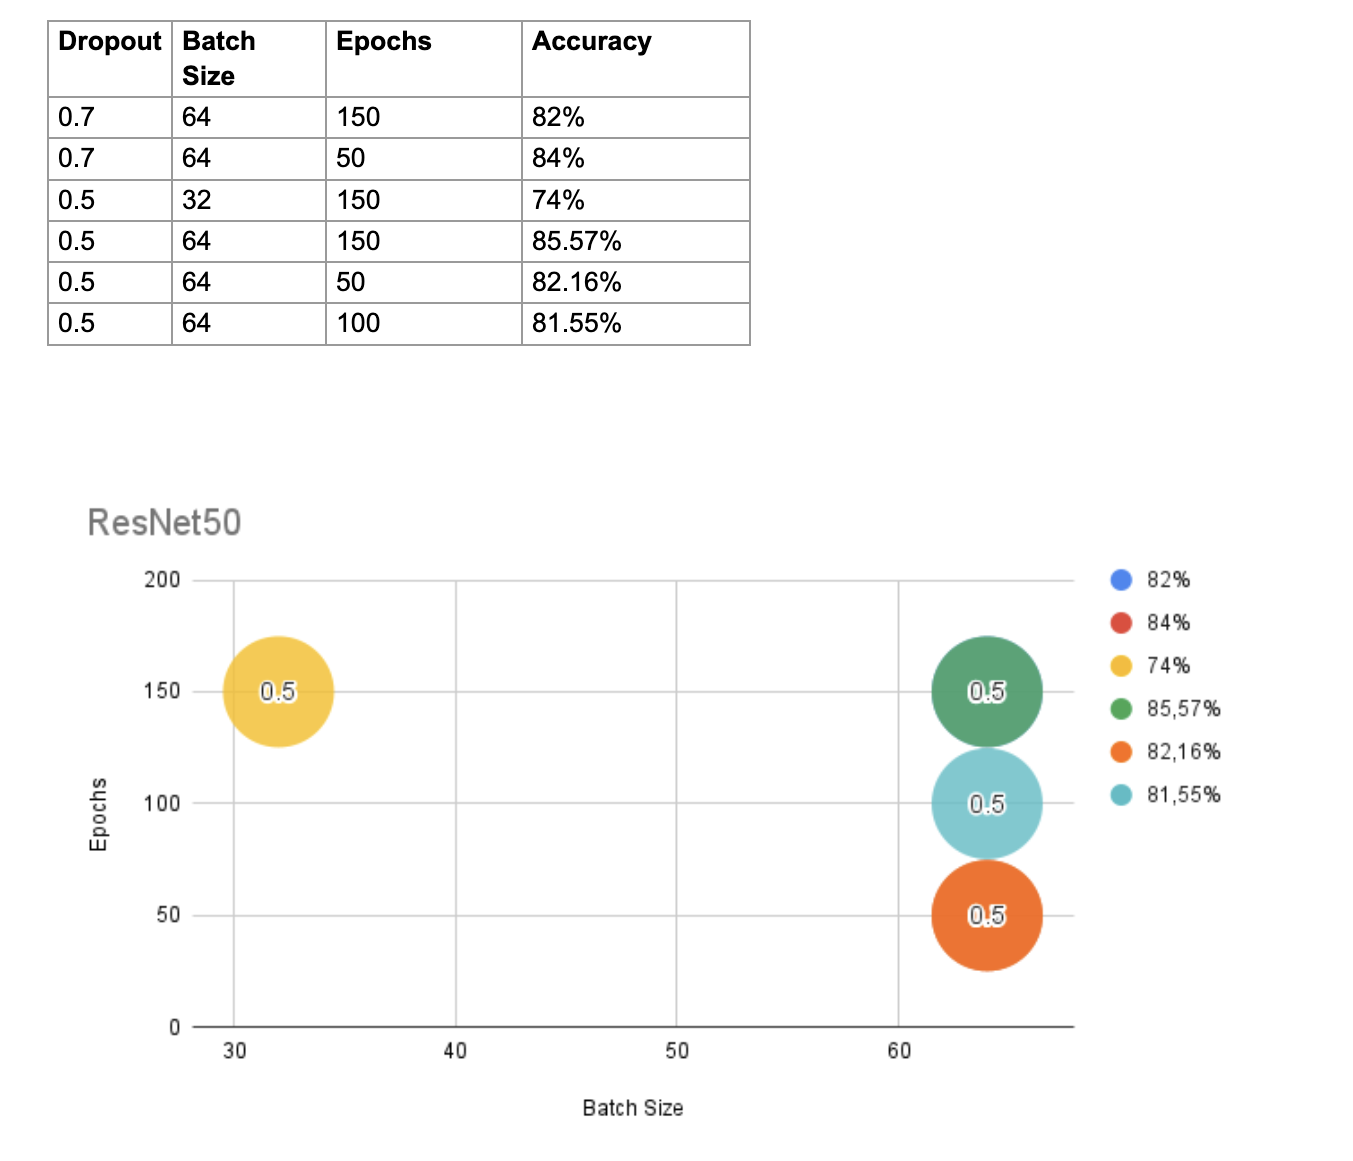

In [ ]:
def run_rest_net_50():
    # Reset TensorFlow graph at the beginning of each run to avoid conflicts
    tf.keras.backend.clear_session()

    # Load preprocessed data
    prep_path = '/kaggle/working/'

    # Define output folder and number of classes
    output_folder = '/kaggle/working/'
    NUM_CLASSES = 3  # Adjust according to your dataset

    # Load augmented data and matched labels
    augmented_images, augmented_labels = load_augmented_data_with_labels(
        output_folder, filtered_labels)

    # Define lists of parameters to experiment with
    optimizers = [Adam()]
    learning_rates = [0.001]
    dropout_rates = [0.5, 0.7]
    batch_sizes = [32,64]
    epochs_range = range(100, 151, 50)

    # Model settings
    model_name = 'ResNet50'

    # Iterate over optimizers
    for optimizer in optimizers:
        for lr in learning_rates:
            for dropout_rate in dropout_rates:
                for batch_size in batch_sizes:
                    for epochs in epochs_range:
                        # Learning Rate Schedule
                        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
                        # Load base model
                        base_model = ResNet50(
                            weights='imagenet', include_top=False, input_shape=(100, 100, 3))
                        print(f"{model_name} base model loaded successfully.")

                        # Fine-tuning
                        for layer in base_model.layers:
                            layer.trainable = True

                        # Regularization (Dropout and L2 Regularization)
                        x = base_model.output
                        x = GlobalAveragePooling2D()(x)
                        x = Dense(256, activation='relu')(x)
                        x = Dropout(dropout_rate)(x)  # Adding dropout layer
                        x = BatchNormalization()(x)  # Adding BatchNormalization layer
                        x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(
                            x)  # Adding L2 regularization
                        x = Dropout(dropout_rate)(x)  # Adding dropout layer
                        predictions = Dense(
                            NUM_CLASSES, activation='softmax')(x)

                        # Create the final model
                        model = Model(inputs=base_model.input,
                                      outputs=predictions)

                        # Compile the model
                        # Recreate optimizer instance
                        optimizer_instance = type(optimizer)()
                        model.compile(
                            optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

                        # Convert labels to one-hot encoded format
                        augmented_labels_one_hot = to_categorical(
                            augmented_labels, num_classes=NUM_CLASSES)

                        # Train-validation split for filtered data
                        train_X, val_X, train_y, val_y = train_test_split(
                            augmented_images, augmented_labels_one_hot, test_size=0.2, random_state=42)

                        # Train the model
                        print(
                            f"Training {model_name} with optimizer {type(optimizer_instance).__name__}, lr={lr}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}...")
                        model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(
                            val_X, val_y), callbacks=[reduce_lr])
                        print(f"{model_name} training completed.")

                        # Predict labels for test images
                        print("Predicting labels for test images...")
                        test_y_pred = model.predict(test_X)
                        test_y_pred_classes = np.argmax(test_y_pred, axis=1)

                        # Create submission DataFrame
                        submission_df = pd.DataFrame(
                            {'id': range(len(test_X)), 'class': test_y_pred_classes})

                        # Save submission to CSV file
                        filename = f'{submissions_folder}/submission_{model_name}_optimizer_{type(optimizer_instance).__name__}_lr_{lr}_dropout_{dropout_rate}_batch_{batch_size}_epochs_{epochs}.csv'
                        submission_df.to_csv(filename, index=False)
                        print(f"Submission saved to {filename}")


# EfficientNetB0

* best results have been obtained with optimizer Adam using learning rate 0.001: the best outcome was accuracy 84.63%

These are the expirements conducted which resulted to the best outcomes: 
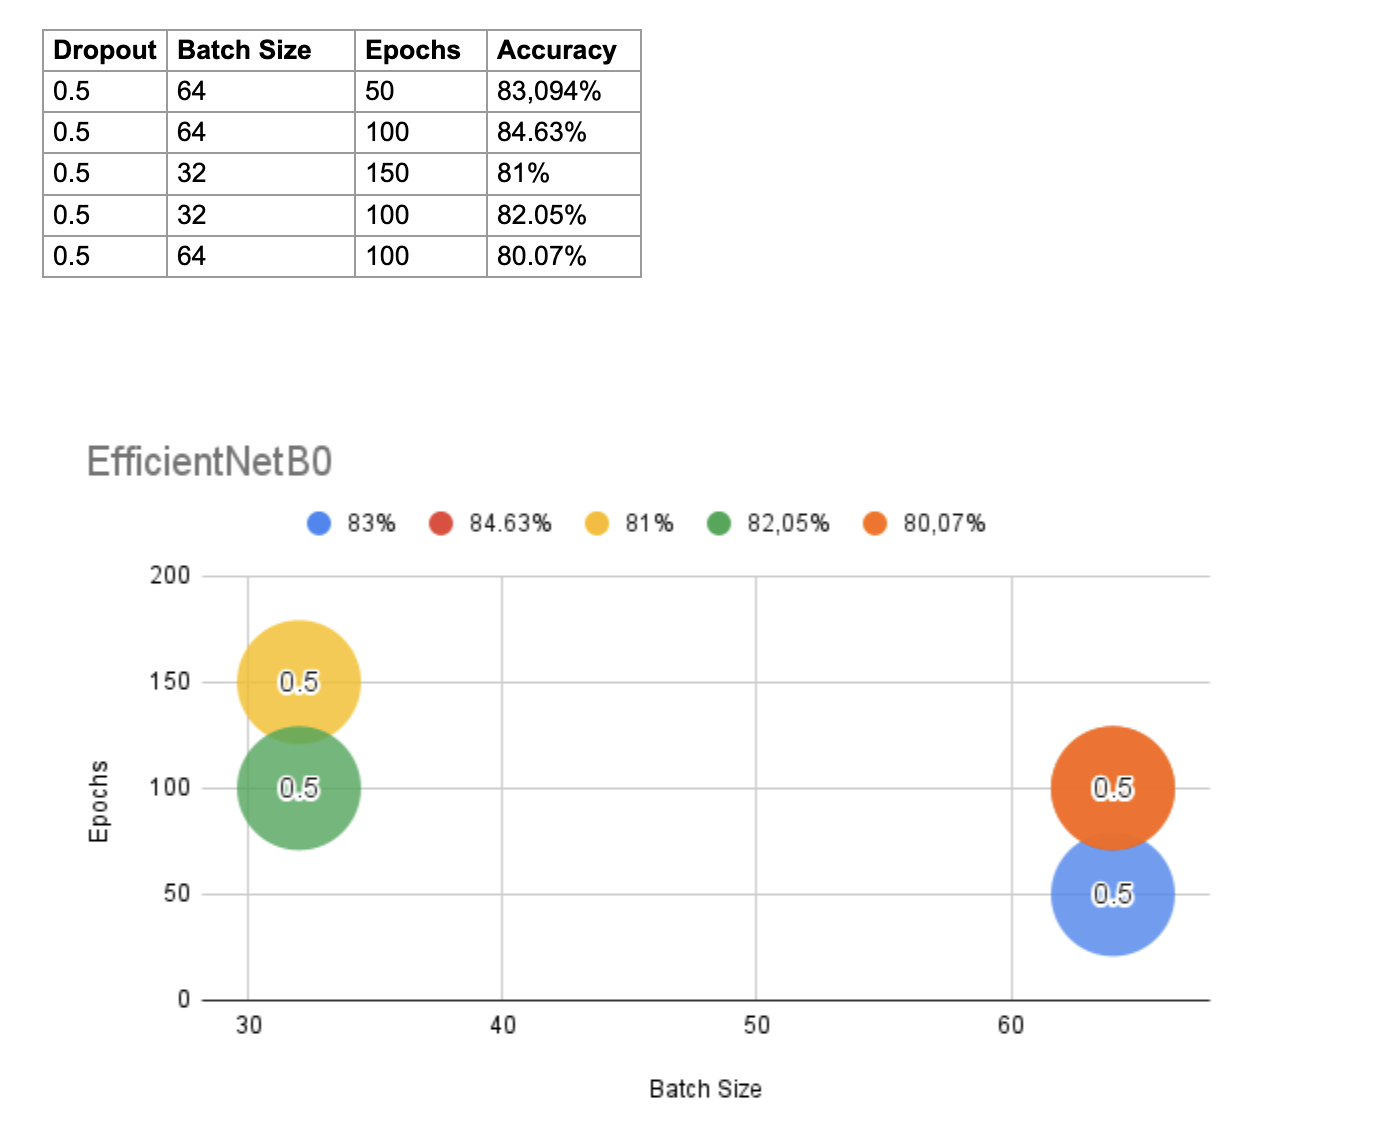


In [ ]:
def run_efficient_net_b0():
    tf.keras.backend.clear_session()

    # Load preprocessed data
    prep_path = '/kaggle/working/'

    # Define output folder and number of classes
    output_folder = '/kaggle/working/'
    NUM_CLASSES = 3  # Adjust according to your dataset

    # Load augmented data and matched labels
    print("Loading augmented data and matched labels...")
    augmented_images, augmented_labels = load_augmented_data_with_labels(
        output_folder, filtered_labels)
    print("Number of augmented images loaded:", len(augmented_images))
    print("Number of matched labels loaded:", len(augmented_labels))
    print("Augmented data and matched labels loaded successfully.")

    # Define lists of parameters to experiment with
    optimizers = [SDG()]
    learning_rates = [0.001]
    dropout_rates = [0.5, 0.7]
    batch_sizes = [32, 64]
    epochs_range = [50, 100, 150]

    # Model settings
    model_name = 'EfficientNetB0'

    # Iterate over optimizers
    for optimizer in optimizers:
        for lr in learning_rates:
            for dropout_rate in dropout_rates:
                for batch_size in batch_sizes:
                    for epochs in epochs_range:
                        # Learning Rate Schedule
                        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

                        # Load base model
                        print(f"Loading {model_name} base model...")
                        base_model = ResNet50(
                            weights='imagenet', include_top=False, input_shape=(100, 100, 3))
                        print(f"{model_name} base model loaded successfully.")

                        # Fine-tuning
                        for layer in base_model.layers:
                            layer.trainable = True

                        # Regularization (Dropout and L2 Regularization)
                        x = base_model.output
                        x = GlobalAveragePooling2D()(x)
                        x = Dense(256, activation='relu')(x)
                        x = Dropout(dropout_rate)(x)  # Adding dropout layer
                        x = BatchNormalization()(x)  # Adding BatchNormalization layer
                        x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(
                            x)  # Adding L2 regularization
                        x = Dropout(dropout_rate)(x)  # Adding dropout layer
                        predictions = Dense(
                            NUM_CLASSES, activation='softmax')(x)

                        # Create the final model
                        model = Model(inputs=base_model.input,
                                      outputs=predictions)

                        # Compile the model
                        # Recreate optimizer instance
                        optimizer_instance = type(optimizer)()
                        model.compile(
                            optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

                        # Convert labels to one-hot encoded format
                        augmented_labels_one_hot = to_categorical(
                            augmented_labels, num_classes=NUM_CLASSES)

                        # Train-validation split for filtered data
                        train_X, val_X, train_y, val_y = train_test_split(
                            augmented_images, augmented_labels_one_hot, test_size=0.2, random_state=42)

                        # Train the model
                        print(
                            f"Training {model_name} with optimizer {type(optimizer_instance).__name__}, lr={lr}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}...")
                        model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(
                            val_X, val_y), callbacks=[reduce_lr])
                        print(f"{model_name} training completed.")

                        # Predict labels for test images
                        print("Predicting labels for test images...")
                        test_y_pred = model.predict(test_X)
                        test_y_pred_classes = np.argmax(test_y_pred, axis=1)

                        # Create submission DataFrame
                        submission_df = pd.DataFrame(
                            {'id': range(len(test_X)), 'class': test_y_pred_classes})

                        # Save submission to CSV file
                        filename = f'{submissions_folder}/submission_{model_name}_optimizer_{type(optimizer_instance).__name__}_lr_{lr}_dropout_{dropout_rate}_batch_{batch_size}_epochs_{epochs}.csv'
                        submission_df.to_csv(filename, index=False)
                        print(f"Submission saved to {filename}")
                        Image(filename='/kaggle/input/reset50/efficient2.png')

# DNN
## FaceNet pytorch

In [ ]:
def prepare_data(train):
    trainFaceList = []
    for i in range(len(train)):
        # These were manually handled because they are missclassified
        if i == 18 or i == 22 or i == 29 or i == 34 or i == 34 or i == 41 or i == 49 or i == 52 or i == 53 or i == 59:
            image = train['img'][i]
            # Get faces
            faces = mtcnn(image)
            # Keep the correct one
            face = faces[1]
            # Normalize to parse into net
            face = (face - face.min()) / (face.max() - face.min())
            trainFaceList.append(face.permute(1, 2, 0).numpy())
        elif i == 28:
            image = train['img'][i]
            faces = mtcnn(image)
            face = faces[2]
            face = (face - face.min()) / (face.max() - face.min())
            trainFaceList.append(face.permute(1, 2, 0).numpy())
        # not an image
        elif i == 65 or i == 78:
            trainFaceList.append(0.0)
            continue
        # all other normal cases
        else:
            image = train['img'][i]
            faces = mtcnn(image)
            face = faces[0]
            face = (face - face.min()) / (face.max() - face.min())
            trainFaceList.append(face.permute(1, 2, 0).numpy())
    # pop bad indexes
    trainFaceList.pop(78)
    trainFaceList.pop(65)
    return trainFaceList


def prepare_test_data(test):
    test['faces'] = None
    # Use it to store objects or it will throw errors
    test['faces'] = test['faces'].astype(object)
    for i in range(len(test)):
        # Read img
        image = test['img'][i]
        # Extract faces using HAAR
        preprocessor = HAARPreprocessor(
            "/kaggle/working/haar_xmls", (SIZE, SIZE))
        face = preprocessor.preprocess({'img': image})
        # If there is a face
        if face is not None:
            # Normalize to model input
            face = (face - np.min(face)) / (np.max(face) - np.min(face))
            # Append to dataset column
            test.at[i, 'faces'] = face.copy()
    normTestFaces = []
    # Iterate over each image in the Series
    for img_array in test['faces']:
        # Convert the entry to a numpy array if it isn't already one
        img_array = np.array(img_array)
        normTestFaces.append(img_array)
    # Optionally, convert the list back to a numpy array
    normTestFaces = np.array(normTestFaces)

    channel_means = np.nanmean(normTestFaces, axis=(0, 1, 2))
    # Replace NaNs in each channel with the corresponding channel mean
    for i in range(normTestFaces.shape[-1]):  # Iterate over channels
        channel = normTestFaces[:, :, :, i]
        mask = np.isnan(channel)  # Find where NaNs are
        channel[mask] = channel_means[i]  # Replace NaNs with the channel mean
    # Normalize to model input
    normTestFaces = 2 * (normTestFaces - np.min(normTestFaces) + 1e-6) / \
        (np.max(normTestFaces) - np.min(normTestFaces) + 1e-6) - 1
    return normTestFaces


def calcClassWeights(labels):
    # labels should be a 1D array of class labels
    classes = np.unique(labels)
    class_weights = compute_class_weight('balanced', classes=classes, y=labels)
    return dict(zip(classes, class_weights))


def run_dnn(train, test, export_name="InceptionResNetV1SVC"):
    trainFaceList = prepare_data(train)
    normTrainFaces = 2 * (trainFaceList - np.min(trainFaceList) + 1e-7) / \
        (np.max(trainFaceList) - np.min(trainFaceList) + 1e-7) - 1
    labels = np.array(train['class'].drop(
        index=[65, 78]).reset_index(drop=True))
    class_weights = calcClassWeights(labels)
    # Setup labels
    torchLabels = torch.from_numpy(
        np.array(train['class'].drop(index=[65, 78]).reset_index(drop=True)))
    normTestFaces = prepare_test_data(test)
    # Initialize parameters for your neural network and data processing
    # Prepare your test dataloader
    test_faces_tensor = torch.from_numpy(
        normTestFaces).permute(0, 3, 1, 2).to(torch.float32)
    test_dataset = TensorDataset(test_faces_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize SVC kernel
    svmModel = svm.SVC(kernel='poly', degree=2, C=0.1, class_weight=class_weights,
                       # because we are people of culture
                       random_state=42)
    # Extract features from training data using your neural network
    train_features = resnet(torch.from_numpy(
        normTrainFaces).permute(0, 3, 1, 2)).detach().numpy()
    # Fit the model
    print("Start SVM model training...")
    svmModel.fit(train_features, torchLabels.detach().numpy())
    print("Finished SVM model training...")

    # List for storing preds
    predictions = []
    # Make predictions with the fitted model on the test set
    # with batches to avoid OOM
    for batch in test_loader:
        images = batch[0]
        with torch.no_grad():
            features = resnet(images).cpu().numpy()
        batch_predictions = svmModel.predict(features)
        predictions.extend(batch_predictions)

    # Create a DataFrame with the predictions
    results_df = pd.DataFrame({
        'id': range(len(predictions)),
        'class': predictions
    })

    # Generate a unique filename for each parameter set
    filename = f'/kaggle/working/{export_name}.csv'
    results_df.to_csv(filename, index=False)
    print(f'Saved predictions to {filename}')

In [ ]:
models_dict = {
    "best": "Inception_ResNet_v1_SVC",
    "efficientNetB0": "EfficientNetB0",
    "resNet50": "ResNet50",
    "ml_svc": "svm",
    "ml_rf": "rf",
    "ml_lr": "lr",
    "ml_xgb": "xgb",
    "ml_knn": "knn",
}


def load_ml_data(train_X, test_X):
    inputData, _ = extractor(train_X)
    testData, _ = extractor(test_X)
    return inputData, testData


if selected_model not in ["Inception_ResNet_v1_SVC", "EfficientNetB0", "ResNet50"]:
    X, x_t = load_ml_data(train_X, test_X)

selected_model = models_dict["best"]
match selected_model:
    case "Inception_ResNet_v1_SVC":
        train = pd.read_csv(
            '/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/train_set.csv', index_col=0)
        train.index = train.index.rename('id')
        train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2024/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB)
                        for index, row in train.iterrows()]
        run_dnn(train, test, "submission")
    case "EfficientNetB0":
        run_efficient_net_b0()
    case "ResNet50":
        run_rest_net_50()
    case "svm":
        svmPipeline = CustomPipeline(category="SVM")
        svmClass = mySVMClassifier()
        svmPipeline.train_pipeline(svmClass, X, x_t)
        svmPipeline.predict_pipeline(testData)
        svmPipeline.save_results()
    case "rf":
        rfPipeline = CustomPipeline(category="RF")
        rfClass = myRandomForestClassifier()
        rfPipeline.train_pipeline(lgClass, X, x_t)
        rfPipeline.predict_pipeline(testData)
        rfPipeline.save_results()
    case "lr":
        lgrPipeline = CustomPipeline(category="LGR")
        lgClass = myLogisticRegressionClassifier()
        lgrPipeline.train_pipeline(lgClass, X, x_t)
        lgrPipeline.predict_pipeline(testData)
        lgrPipeline.save_results()
    case "xgb":
        import cupy
        xgboostPipeline = CustomPipeline(category="XGBOOST")
        xgbClass = myXGBoostClassifier()
        xgboostPipeline.train_pipeline(xgbClass, cupy.array(X), x_t)
        xgboostPipeline.predict_pipeline(testData)
        xgboostPipeline.save_results()
    case "knn":
        knnPipeline = CustomPipeline(category="KNN")
        knnClass = myKNNClassifier()
        knnPipeline.train_pipeline(knnClass, X, x_t)
        knnPipeline.predict_pipeline(testData)
        knnPipeline.save_results()

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis=1)
submission['class'] = predictions
submission.to_csv('submission.csv')
submission

# 6. Discussion
# DNN Section

## Hybrid Approaches
Here we tried out some hybrid approaches, utilizing pretrained models for their output embeddings and using more traditional methods to classify the images

### 1st approach
Here we used the mtcnn and InceptionV1 architectures from the facenet-pytorch library </br>
The first one was utilized to extract faces from the train dataset. </br>
Some faces were inorderly extracted and done manually </br>
Images with index 65 and 78 were not detected and were left out. </br>
The InceptionResNetV1 architecture was used for its embeddings </br>
The embeddings were then later used for calculating the manhattan distance of any test image </br>
with the remaining 78 of the train one for classification. </br>
The results were underwhelming with an accuracy of around 0.55 and as such </br>
the code was left out of the report. </br>

### 2nd approach
Here we utilized again the same way the face extraction by mtcnn, </br>
then parsed the embeddings through InceptionResNetV1 and EfficientNetV2M, </br>
following by an SVM classifier. The model of InceptionResNetV1 reached a peak performance of 0.917 </br>
for the polynomial kernel of degree 2, a regularization coefficient C of 0.1 with class weights</br>
and is displayed above.

---

## Pure DNN
## Augmentations
Due to limited data, in order to perform Deep Learning Classification,</br>
several augmentations were performed:
- vertical shift
- horizontal shift
- sigmoid correction
- gamma correction (gamma=0.3, gain=0.9)
- logarithmic correction 
- lighter image (gamma=0.5, gain=1.)
- darker image (gamma=2., gain=1.)
- adding random gaussian noise to the image
- applying clockwise rotation (pi/4 rad)
- applying anticlockwise rotation (-pi/4 rad)
- applying width shift
- applying height shift
- applying shear
- zooming

### 1st Pure
In order to start trying out models, the first one used was a light weight model</br>
named GhostNetV2 from paperwithcode.com. The model was chosen since it</br>
provided state of the art results on face recognition in addition to being light </br>
results were max at the range of 0.55, probably due to overfitting and were left out </br>
experiments wew done with 10-fold stratified cross-validation.

### 2nd Pure
Then a SwinV2 transformer was utilized pretrained on the imagenet dataset, </br>
but yielded even more subpar results at an accuracy round 0.4. </br>
Again 10-fold cross-validation was utilized.

### 3rd Pure
Then we utilized a multitude of models looking for quick and dirty results from the keras.applications </br>
The models utilized were:
- EfficientNetV2M
- EfficientNetB0
- MobileNet
- MobileNetV2
- InceptionV2
- InceptionV3
- NASNetMobile
- DenseNet121
- Xception

Here a grid search was done for:</br>
- ResNet50
1. dropout rates: 0.5, 0.7 </br>
2. bach sizes: 32, 64 </br>
3. epochs 50, 100, 150 </br>
4. learning rats: 0.001 </br>
5. optimizer: Adam </br>

- EfficientNetB0
1. dropout rates: 0.5 </br>
2. bach sizes: 32, 64 </br>
3. epochs 50, 100, 150 </br>
4. learning rats: 0.001 </br>
5. optimizer: SDG </br>

---

## Appendix

### Augmentations

#### Sigmoid correction
Enhances the contrast of an image by mapping its intensity levels onto a sigmoidal curve. This can make details in both the shadows and highlights more visible, improving the perceptual quality of the image by: </br>

$V_{\text{out}} = \frac{1}{1 + \exp(-\text{gain} \cdot (V_{\text{in}} - \text{cutoff}))}$ </br>

where: </br>
gain = 1 by default </br>
and cutoff = 0.5 </br>

#### Gamma Correction
Gamma correction is a nonlinear operation used to encode and decode luminance or color values in image systems. It's particularly useful in adjusting the way images appear on different devices, compensating for the effect of the physical properties of display systems. The following is applied: </br>
$ V_{\text{out}} = A \times (V_{\text{in}})^\gamma $ </br>
Where:
- $V_{\text{in}}$ is the input pixel value (normalized between 0 and 1),
- $\gamma$ is the gamma correction value,
- $A$ represents the gain factor, adjusting the overall brightness,
- $V_{\text{out}}$ is the output pixel value after applying gamma correction.

#### Log correction
The function applies a logarithmic transformation to enhance details in darker areas of images by compressing the dynamic range via:

$ V_{\text{out}} = c \cdot \ln(1 + V_{\text{in}}) $

where:
- $V_{\text{in}}$ is the input pixel value,
- $c$ is a scaling constant to adjust the output range,
- $V_{\text{out}}$ is the output pixel value after applying the logarithmic transformation.

This transformation is especially useful in images with large dynamic ranges, helping to bring out details in shadows while maintaining a realistic representation of brighter areas.

$c = \frac{255}{\ln(1 + 255)}$

#### Shear
This function can be used to artificially expand the diversity of image data available for training an image processing model, making the model more versatile and robust against variations in input data by rotating around the x or y axis by an factor specified.